# Corporate Resilience Project - Disaster Exposure & Analysis
## Notebook 4: Calculate Resilience Metrics and Financial Ratios

**Research Objective:** Analyze how natural disasters affect corporate operations and financial performance

**Key Analyses:**
1. Link facilities to disaster events (using FIPS codes)
2. Calculate disaster exposure metrics
3. Measure operational impacts (TRI emissions changes)
4. Compute financial performance ratios
5. Build resilience indicators
6. Prepare dataset for econometric analysis

**Inputs:**
- `tri_facilities_matched_final.parquet` (matched TRI-CRSP data)
- `county_fips_crosswalk.csv` (county codes)
- SHELDUS disaster data
- SEC EDGAR financial statements (future integration)

**Outputs:**
- `facility_disaster_exposure.csv` - Facility-level disaster events
- `company_disaster_summary.csv` - Company-level aggregation
- `resilience_metrics.csv` - Calculated resilience indicators
- `analysis_dataset.parquet` - Complete dataset for modeling


In [ ]:
# Setup
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Define paths
BASE_PATH = Path('/content/drive/MyDrive/Paper1_Dataset')
PROCESSED_PATH = BASE_PATH / 'processed'
SHELDUS_PATH = BASE_PATH / 'SHELDUS'  # ← ADD THIS!

print("✓ Libraries loaded")
print(f"✓ Base path: {BASE_PATH}")
print(f"✓ Processed path: {PROCESSED_PATH}")
print(f"✓ SHELDUS path: {SHELDUS_PATH}")  # ← ADD THIS!

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Libraries loaded
✓ Base path: /content/drive/MyDrive/Paper1_Dataset
✓ Processed path: /content/drive/MyDrive/Paper1_Dataset/processed
✓ SHELDUS path: /content/drive/MyDrive/Paper1_Dataset/SHELDUS


## 1. Load Matched Data

In [ ]:
print("="*80)
print("LOADING DATA")
print("="*80)

# Load matched TRI-CRSP data
tri_matched = pd.read_parquet(PROCESSED_PATH / 'tri_facilities_matched_final.parquet')
print(f"\n✓ TRI facilities: {len(tri_matched):,} records")
print(f"  Unique facilities: {tri_matched['TRIFD'].nunique():,}")
print(f"  With CRSP match: {tri_matched['PERMNO'].notna().sum():,} ({tri_matched['PERMNO'].notna().sum()/len(tri_matched)*100:.1f}%)")
print(f"  Years: {tri_matched['DATA_YEAR'].min()}-{tri_matched['DATA_YEAR'].max()}")

# Check what columns exist
print(f"\nAvailable columns ({len(tri_matched.columns)}):")
print(tri_matched.columns.tolist())

# Check if FIPS exists
if 'FIPS' in tri_matched.columns:
    print(f"\n✓ FIPS code coverage:")
    print(f"  With FIPS: {tri_matched['FIPS'].notna().sum():,} ({tri_matched['FIPS'].notna().sum()/len(tri_matched)*100:.1f}%)")
else:
    print(f"\n⚠️  FIPS column not found - will need to create it")

    # Try to create FIPS from STATE_ABBR and FACILITY_COUNTY
    if 'STATE_ABBR' in tri_matched.columns and 'FACILITY_COUNTY' in tri_matched.columns:
        print(f"  Attempting to create FIPS from STATE + COUNTY...")

        # Load county crosswalk if available
        try:
            county_crosswalk = pd.read_csv(PROCESSED_PATH / 'county_fips_crosswalk.csv')

            # Standardize county names for matching
            tri_matched['FACILITY_COUNTY_STD'] = tri_matched['FACILITY_COUNTY'].str.upper().str.strip()
            county_crosswalk['COUNTY_NAME_STD'] = county_crosswalk['COUNTY_NAME_STD'].str.upper().str.strip()

            # Merge
            tri_matched = tri_matched.merge(
                county_crosswalk[['STATE_ABBR', 'COUNTY_NAME_STD', 'FIPS']],
                left_on=['STATE_ABBR', 'FACILITY_COUNTY_STD'],
                right_on=['STATE_ABBR', 'COUNTY_NAME_STD'],
                how='left'
            )

            print(f"  ✓ FIPS created: {tri_matched['FIPS'].notna().sum():,} matched ({tri_matched['FIPS'].notna().sum()/len(tri_matched)*100:.1f}%)")
        except Exception as e:
            print(f"  ✗ Could not create FIPS: {e}")
            tri_matched['FIPS'] = None
    else:
        print(f"  ✗ Cannot create FIPS - missing STATE or COUNTY columns")
        tri_matched['FIPS'] = None

print("\n" + "="*80)

LOADING DATA

✓ TRI facilities: 1,148,673 records
  Unique facilities: 29,176
  With CRSP match: 245,826 (21.4%)
  Years: 2009-2023

Available columns (29):
['TRIFD', 'REPORTING_YEAR', 'FACILITY_STREET', 'FACILITY_CITY', 'FACILITY_COUNTY', 'FACILITY_STATE', 'FACILITY_ZIP', 'UNKNOWN_1', 'PARENT_COMPANY', 'PARENT_COMPANY_STD', 'MAILING_NAME', 'MAILING_STREET', 'MAILING_CITY', 'MAILING_STATE', 'COMPANY_NAME', 'DATA_YEAR', 'COMPANY_NAME_STD', 'STATE_ABBR', 'FACILITY_COUNTY_STD', 'COUNTY_NAME_STD', 'COUNTY_NAME', 'COUNTY_NAME_STD_census', 'FIPS', 'COUNTY_NAME_census', 'TRI_COMPANY_ID', 'PERMNO', 'TICKER', 'CUSIP9', 'MATCH_SCORE']

✓ FIPS code coverage:
  With FIPS: 1,136,098 (98.9%)



## 2. Load and Process SHELDUS Disaster Data

In [ ]:
print("="*80)
print("LOADING SHELDUS DISASTER DATA")
print("="*80)

# Check for SHELDUS data
sheldus_file = SHELDUS_PATH / 'CorporateResilienceProject' / 'data' / 'processed' / 'sheldus_events.parquet'

if sheldus_file.exists():
    disasters = pd.read_parquet(sheldus_file)
    print(f"\n✓ SHELDUS loaded: {len(disasters):,} disaster events")

    # Process dates
    if 'begin_date' in disasters.columns:
        disasters['year'] = pd.to_datetime(disasters['begin_date']).dt.year
        disasters['month'] = pd.to_datetime(disasters['begin_date']).dt.month

    # Filter to analysis window
    analysis_years = range(tri_matched['DATA_YEAR'].min(), tri_matched['DATA_YEAR'].max() + 1)
    disasters = disasters[disasters['year'].isin(analysis_years)]

    print(f"  Filtered to {tri_matched['DATA_YEAR'].min()}-{tri_matched['DATA_YEAR'].max()}: {len(disasters):,} events")
    print(f"  Unique counties affected: {disasters['county_fips'].nunique():,}")

    # Check available columns
    print(f"\nAvailable columns:")
    print(disasters.columns.tolist())

    # Disaster types
    if 'hazard_type' in disasters.columns:
        print(f"\nDisaster types:")
        print(disasters['hazard_type'].value_counts().head(15))

else:
    print(f"\n⚠️  SHELDUS file not found at: {sheldus_file}")
    print("\nExpected location: .../SHELDUS/CorporateResilienceProject/data/processed/sheldus_events.parquet")
    print("\nPlease check your SHELDUS data location and update path.")
    disasters = None

print("\n" + "="*80)

LOADING SHELDUS DISASTER DATA

✓ SHELDUS loaded: 141,486 disaster events
  Filtered to 2009-2023: 35,283 events
  Unique counties affected: 2,367

Available columns:
['county_fips', 'begin_date', 'end_date', 'hazard', 'property_damage', 'fatalities', 'injuries', 'event_date', 'event_id', 'source_file', 'year', 'month']



## 3. Link Facilities to Disasters (County-Level)

In [ ]:
if disasters is not None:
    print("="*80)
    print("LINKING FACILITIES TO DISASTERS (FIXED)")
    print("="*80)

    # Filter TRI to records with FIPS
    tri_with_fips = tri_matched[tri_matched['FIPS'].notna()].copy()
    print(f"\nFacility-years with FIPS: {len(tri_with_fips):,}")

    # FIX: Convert FIPS properly (remove .0 decimal)
    print("\nFixing FIPS format...")

    # TRI FIPS: Convert float → int → string → pad to 5 digits
    tri_with_fips['FIPS_clean'] = (
        tri_with_fips['FIPS']
        .astype(float)           # Ensure it's float
        .astype(int)             # Convert to int (removes .0)
        .astype(str)             # Convert to string
        .str.zfill(5)            # Pad to 5 digits
    )

    # SHELDUS FIPS: Already clean, just ensure 5 digits
    disasters['county_fips_clean'] = disasters['county_fips'].astype(str).str.zfill(5)

    print(f"Sample TRI FIPS after fix: {sorted(tri_with_fips['FIPS_clean'].unique())[:10]}")
    print(f"Sample SHELDUS FIPS: {sorted(disasters['county_fips_clean'].unique())[:10]}")

    # Check overlap now
    tri_fips_set = set(tri_with_fips['FIPS_clean'].unique())
    disaster_fips_set = set(disasters['county_fips_clean'].unique())
    overlap = tri_fips_set & disaster_fips_set
    print(f"\n✓ FIPS overlap found: {len(overlap):,} counties")

    if len(overlap) == 0:
        print("\n⚠️  Still no overlap - county FIPS matching needs improvement")
        print("   Only 129 unique FIPS in TRI (very low coverage)")
        print("   Recommend: Fix county matching in Notebook 1")
        tri_matched['num_disasters'] = 0
        tri_matched['disaster_exposed'] = 0
    else:
        # Select columns for merge
        merge_cols = ['county_fips_clean', 'year']
        optional_cols = ['hazard', 'begin_date', 'property_damage', 'injuries', 'fatalities']
        for col in optional_cols:
            if col in disasters.columns:
                merge_cols.append(col)

        print(f"\nMerging on: {merge_cols[:2]}")

        # Merge: facility-year × disaster
        facility_disasters = tri_with_fips.merge(
            disasters[merge_cols],
            left_on=['FIPS_clean', 'DATA_YEAR'],
            right_on=['county_fips_clean', 'year'],
            how='left',
            indicator=True
        )

        # Count disasters per facility-year
        disaster_counts = facility_disasters.groupby(['TRIFD', 'DATA_YEAR']).agg({
            '_merge': lambda x: (x == 'both').sum()
        }).rename(columns={'_merge': 'num_disasters'})

        # Statistics
        exposed_facility_years = (disaster_counts['num_disasters'] > 0).sum()
        print(f"\n✓ Facility-years exposed to disasters: {exposed_facility_years:,} ({exposed_facility_years/len(tri_with_fips)*100:.1f}%)")

        if exposed_facility_years > 0:
            print(f"\nDisaster exposure distribution:")
            exp_dist = disaster_counts[disaster_counts['num_disasters'] > 0]['num_disasters'].value_counts().sort_index()
            print(exp_dist.head(10))

            # Save detailed exposure
            exposure_detail = facility_disasters[facility_disasters['_merge'] == 'both'].copy()
            output_file = PROCESSED_PATH / 'facility_disaster_exposure_detail.csv'
            exposure_detail.to_csv(output_file, index=False)
            print(f"\n✓ Detailed exposure saved: {output_file}")

        # Merge back to main dataset
        tri_matched = tri_matched.merge(
            disaster_counts,
            on=['TRIFD', 'DATA_YEAR'],
            how='left'
        )
        tri_matched['num_disasters'] = tri_matched['num_disasters'].fillna(0)
        tri_matched['disaster_exposed'] = (tri_matched['num_disasters'] > 0).astype(int)

        print(f"\n✓ Disaster linkage complete")
        print(f"  Total exposed facility-years: {tri_matched['disaster_exposed'].sum():,}")

else:
    print("\n⚠️  Skipping disaster linkage - SHELDUS data not available")
    tri_matched['num_disasters'] = 0
    tri_matched['disaster_exposed'] = 0

print("\n" + "="*80)

LINKING FACILITIES TO DISASTERS (FIXED)

Facility-years with FIPS: 1,136,098

Fixing FIPS format...
Sample TRI FIPS after fix: ['01001', '01003', '01005', '01007', '01009', '01011', '01013', '01015', '01017', '01019']
Sample SHELDUS FIPS: ['01001', '01003', '01007', '01009', '01013', '01015', '01017', '01019', '01023', '01025']

✓ FIPS overlap found: 2,003 counties

Merging on: ['county_fips_clean', 'year']

✓ Facility-years exposed to disasters: 73,246 (6.4%)

Disaster exposure distribution:
num_disasters
1      228
2     8527
3      482
4     8826
5      119
6     6376
7       99
8     8023
9      161
10    2477
Name: count, dtype: int64

✓ Detailed exposure saved: /content/drive/MyDrive/Paper1_Dataset/processed/facility_disaster_exposure_detail.csv

✓ Disaster linkage complete
  Total exposed facility-years: 364,620



## 4. Calculate Facility-Level Operational Metrics

Using TRI emissions as proxy for production/operational activity

In [ ]:
print("="*80)
print("CALCULATING OPERATIONAL METRICS")
print("="*80)

# Note: Full TRI emissions data would come from other TRI files (2a, 3a, etc.)
# For now, we use facility reporting as indicator of operational status

# 1. Facility operational continuity
facility_years = tri_matched.groupby('TRIFD')['DATA_YEAR'].apply(list).to_dict()

def calculate_gaps(years):
    """Calculate number of years facility didn't report (possible closure)"""
    if len(years) == 0:
        return 0
    years_sorted = sorted(years)
    expected_years = set(range(min(years_sorted), max(years_sorted) + 1))
    return len(expected_years - set(years))

facility_metrics = pd.DataFrame([
    {
        'TRIFD': trifd,
        'years_operating': len(years),
        'first_year': min(years),
        'last_year': max(years),
        'years_gap': calculate_gaps(years)
    }
    for trifd, years in facility_years.items()
])

print(f"\nFacility operational metrics:")
print(f"  Total facilities: {len(facility_metrics):,}")
print(f"  Avg years operating: {facility_metrics['years_operating'].mean():.1f}")
print(f"  Facilities with gaps: {(facility_metrics['years_gap'] > 0).sum():,}")

# 2. Merge back to main dataset
tri_matched = tri_matched.merge(facility_metrics[['TRIFD', 'years_operating', 'years_gap']], on='TRIFD', how='left')

print("\n✓ Operational metrics calculated")
print("\n" + "="*80)

CALCULATING OPERATIONAL METRICS

Facility operational metrics:
  Total facilities: 29,176
  Avg years operating: 39.4
  Facilities with gaps: 19,252

✓ Operational metrics calculated



## 5. Company-Level Disaster Exposure Aggregation

In [ ]:
print("="*80)
print("COMPANY-LEVEL DISASTER EXPOSURE")
print("="*80)

# Aggregate to company-year level
company_year = tri_matched[tri_matched['PERMNO'].notna()].groupby(['PERMNO', 'TICKER', 'DATA_YEAR']).agg({
    'TRIFD': 'nunique',  # Number of facilities
    'num_disasters': 'sum',  # Total disasters across all facilities
    'disaster_exposed': 'sum',  # Number of facilities exposed
    'STATE_ABBR': 'nunique'  # Geographic diversity
}).reset_index()

company_year.columns = ['PERMNO', 'TICKER', 'Year', 'Num_Facilities', 'Total_Disasters',
                        'Facilities_Exposed', 'States_Operating']

# Calculate exposure intensity
company_year['Pct_Facilities_Exposed'] = (company_year['Facilities_Exposed'] / company_year['Num_Facilities'] * 100).round(1)
company_year['Disasters_Per_Facility'] = (company_year['Total_Disasters'] / company_year['Num_Facilities']).round(2)

print(f"\nCompany-year observations: {len(company_year):,}")
print(f"  Unique companies: {company_year['PERMNO'].nunique():,}")
print(f"  Years covered: {company_year['Year'].min()}-{company_year['Year'].max()}")

print(f"\nDisaster exposure summary:")
print(f"  Company-years with any exposure: {(company_year['Facilities_Exposed'] > 0).sum():,} ({(company_year['Facilities_Exposed'] > 0).sum()/len(company_year)*100:.1f}%)")
print(f"  Avg facilities per company: {company_year['Num_Facilities'].mean():.1f}")
print(f"  Avg disasters per exposed company-year: {company_year[company_year['Total_Disasters']>0]['Total_Disasters'].mean():.1f}")

# Save
output_file = PROCESSED_PATH / 'company_disaster_summary.csv'
company_year.to_csv(output_file, index=False)
print(f"\n✓ Saved: {output_file}")

print("\n" + "="*80)

COMPANY-LEVEL DISASTER EXPOSURE

Company-year observations: 4,910
  Unique companies: 395
  Years covered: 2009-2023

Disaster exposure summary:
  Company-years with any exposure: 2,738 (55.8%)
  Avg facilities per company: 6.8
  Avg disasters per exposed company-year: 4226.0

✓ Saved: /content/drive/MyDrive/Paper1_Dataset/processed/company_disaster_summary.csv



## 6. Temporal Analysis: Pre vs Post-Disaster

In [ ]:
print("="*80)
print("TEMPORAL DISASTER IMPACT ANALYSIS")
print("="*80)

# Get exposed facility-years
exposed_facilities = tri_matched[tri_matched['disaster_exposed'] == 1].copy()
print(f"\nFacility-years with disaster exposure: {len(exposed_facilities):,}")

if len(exposed_facilities) > 0:
    # Create list of all (facility, disaster_year) pairs
    disaster_events = exposed_facilities[['TRIFD', 'DATA_YEAR']].rename(
        columns={'DATA_YEAR': 'disaster_year'}
    ).drop_duplicates()

    print(f"Unique disaster events: {len(disaster_events):,}")

    # Cross join with all years in window
    # Create event time windows: -2, -1, 0, +1, +2
    event_times = pd.DataFrame({'event_time': range(-2, 3)})

    # Create all combinations of (facility, disaster_year, event_time)
    event_structure = disaster_events.merge(event_times, how='cross')
    event_structure['target_year'] = event_structure['disaster_year'] + event_structure['event_time']

    print(f"\nEvent structure created: {len(event_structure):,} potential observations")

    # Merge with actual facility data (VECTORIZED!)
    event_panel = event_structure.merge(
        tri_matched,
        left_on=['TRIFD', 'target_year'],
        right_on=['TRIFD', 'DATA_YEAR'],
        how='inner'
    )

    print(f"\nEvent study panel created:")
    print(f"  Total observations: {len(event_panel):,}")
    print(f"  Unique facilities: {event_panel['TRIFD'].nunique():,}")
    print(f"  Unique disaster events: {event_panel['disaster_year'].nunique():,}")

    print(f"\nObservations by event time:")
    event_time_counts = event_panel['event_time'].value_counts().sort_index()
    for time, count in event_time_counts.items():
        label = "disaster year" if time == 0 else f"t{time:+d}"
        print(f"  {label:15s}: {count:6,}")

    # Save
    output_file = PROCESSED_PATH / 'disaster_event_study_panel.parquet'
    event_panel.to_parquet(output_file, index=False)
    print(f"\n✓ Saved: {output_file}")

else:
    print("\n⚠️  No exposed facilities found")

print("\n" + "="*80)

TEMPORAL DISASTER IMPACT ANALYSIS

Facility-years with disaster exposure: 364,620
Unique disaster events: 73,246

Event structure created: 366,230 potential observations

Event study panel created:
  Total observations: 1,544,221
  Unique facilities: 20,779
  Unique disaster events: 12

Observations by event time:
  t-2            : 255,584
  t-1            : 289,401
  disaster year  : 364,620
  t+1            : 320,479
  t+2            : 314,137

✓ Saved: /content/drive/MyDrive/Paper1_Dataset/processed/disaster_event_study_panel.parquet



## 7. Financial Performance Ratios Framework

**Note:** This requires SEC EDGAR financial statement data (Compustat or manual extraction).  
For now, we create the framework and placeholder calculations.

In [ ]:
print("="*80)
print("FINANCIAL RATIOS FRAMEWORK")
print("="*80)

print("\nKEY FINANCIAL RATIOS TO CALCULATE:")
print("-" * 80)

financial_ratios = [
    ("Profitability Ratios", [
        "ROA = Net Income / Total Assets",
        "ROE = Net Income / Shareholders' Equity",
        "Profit Margin = Net Income / Revenue",
        "Operating Margin = Operating Income / Revenue"
    ]),
    ("Liquidity Ratios", [
        "Current Ratio = Current Assets / Current Liabilities",
        "Quick Ratio = (Current Assets - Inventory) / Current Liabilities",
        "Cash Ratio = Cash / Current Liabilities"
    ]),
    ("Leverage Ratios", [
        "Debt-to-Equity = Total Debt / Shareholders' Equity",
        "Debt-to-Assets = Total Debt / Total Assets",
        "Interest Coverage = EBIT / Interest Expense"
    ]),
    ("Efficiency Ratios", [
        "Asset Turnover = Revenue / Total Assets",
        "Inventory Turnover = COGS / Average Inventory"
    ])
]

for category, ratios in financial_ratios:
    print(f"\n{category}:")
    for ratio in ratios:
        print(f"  • {ratio}")

print("\n" + "="*80)
print("DATA SOURCES FOR FINANCIAL RATIOS:")
print("-" * 80)
print("\n1. SEC EDGAR 10-K/10-Q filings (manual extraction)")
print("2. Compustat database (if available)")
print("3. CRSP stock returns (for market-based metrics)")

print("\n⚠️  TO DO: Integrate SEC EDGAR financial data")
print("   Options:")
print("   A) Extract from your 'SEC EDGAR' folder")
print("   B) Use Compustat if you have access")
print("   C) Use WRDS or similar database")

print("\n" + "="*80)

FINANCIAL RATIOS FRAMEWORK

KEY FINANCIAL RATIOS TO CALCULATE:
--------------------------------------------------------------------------------

Profitability Ratios:
  • ROA = Net Income / Total Assets
  • ROE = Net Income / Shareholders' Equity
  • Profit Margin = Net Income / Revenue
  • Operating Margin = Operating Income / Revenue

Liquidity Ratios:
  • Current Ratio = Current Assets / Current Liabilities
  • Quick Ratio = (Current Assets - Inventory) / Current Liabilities
  • Cash Ratio = Cash / Current Liabilities

Leverage Ratios:
  • Debt-to-Equity = Total Debt / Shareholders' Equity
  • Debt-to-Assets = Total Debt / Total Assets
  • Interest Coverage = EBIT / Interest Expense

Efficiency Ratios:
  • Asset Turnover = Revenue / Total Assets
  • Inventory Turnover = COGS / Average Inventory

DATA SOURCES FOR FINANCIAL RATIOS:
--------------------------------------------------------------------------------

1. SEC EDGAR 10-K/10-Q filings (manual extraction)
2. Compustat database 

## 8. Resilience Indicators

Measure company ability to withstand and recover from disasters

In [ ]:
print("="*80)
print("RESILIENCE INDICATORS")
print("="*80)

# 1. Geographic Diversity (reduces concentration risk)
company_diversity = tri_matched[tri_matched['PERMNO'].notna()].groupby('PERMNO').agg({
    'STATE_ABBR': 'nunique',
    'FIPS': 'nunique',
    'TRIFD': 'nunique'
}).rename(columns={
    'STATE_ABBR': 'states_operating',
    'FIPS': 'counties_operating',
    'TRIFD': 'total_facilities'
})

# Calculate concentration
company_diversity['geographic_concentration'] = 1 / company_diversity['states_operating']

print(f"\nGeographic Diversity Metrics:")
print(f"  Avg states per company: {company_diversity['states_operating'].mean():.1f}")
print(f"  Avg facilities per company: {company_diversity['total_facilities'].mean():.1f}")
print(f"\nConcentration distribution:")
print(company_diversity['geographic_concentration'].describe())

# 2. Disaster History (past exposure)
company_disaster_history = tri_matched[tri_matched['PERMNO'].notna()].groupby('PERMNO').agg({
    'disaster_exposed': 'sum',  # Total facility-years exposed
    'num_disasters': 'sum',  # Total disasters experienced
    'DATA_YEAR': 'nunique'  # Years operating
})

company_disaster_history['disaster_exposure_rate'] = (
    company_disaster_history['disaster_exposed'] /
    (company_disaster_history['DATA_YEAR'] * company_diversity['total_facilities'])
).fillna(0)

print(f"\nDisaster Exposure History:")
print(f"  Companies with any exposure: {(company_disaster_history['disaster_exposed'] > 0).sum():,}")
print(f"  Avg exposure rate: {company_disaster_history['disaster_exposure_rate'].mean():.3f}")

# 3. Operational Continuity
company_continuity = tri_matched[tri_matched['PERMNO'].notna()].groupby('PERMNO').agg({
    'years_gap': 'sum',  # Total gaps across all facilities
    'TRIFD': 'nunique'
})

company_continuity['avg_facility_gaps'] = company_continuity['years_gap'] / company_continuity['TRIFD']

print(f"\nOperational Continuity:")
print(f"  Avg facility gaps: {company_continuity['avg_facility_gaps'].mean():.2f} years")

# Combine all resilience metrics
resilience_metrics = company_diversity.join(company_disaster_history[['disaster_exposure_rate', 'num_disasters']])
resilience_metrics = resilience_metrics.join(company_continuity[['avg_facility_gaps']])

# Save
output_file = PROCESSED_PATH / 'company_resilience_metrics.csv'
resilience_metrics.to_csv(output_file)
print(f"\n✓ Saved: {output_file}")

print("\n" + "="*80)

RESILIENCE INDICATORS

Geographic Diversity Metrics:
  Avg states per company: 4.0
  Avg facilities per company: 5.8

Concentration distribution:
count    1016.000000
mean        0.574622
std         0.378246
min         0.025000
25%         0.200000
50%         0.500000
75%         1.000000
max         1.000000
Name: geographic_concentration, dtype: float64

Disaster Exposure History:
  Companies with any exposure: 874
  Avg exposure rate: 0.876

Operational Continuity:
  Avg facility gaps: 34.52 years

✓ Saved: /content/drive/MyDrive/Paper1_Dataset/processed/company_resilience_metrics.csv



## 9. Descriptive Statistics for Research Paper

In [ ]:
print("="*80)
print("DESCRIPTIVE STATISTICS (TABLE 1 for Paper)")
print("="*80)

# Panel A: Sample characteristics
print("\nPANEL A: SAMPLE COMPOSITION")
print("-" * 80)
print(f"Unique companies (CRSP): {tri_matched[tri_matched['PERMNO'].notna()]['PERMNO'].nunique():,}")
print(f"Unique facilities (TRI): {tri_matched['TRIFD'].nunique():,}")
print(f"Facility-year observations: {len(tri_matched):,}")
print(f"Years covered: {tri_matched['DATA_YEAR'].min()}-{tri_matched['DATA_YEAR'].max()}")
print(f"States represented: {tri_matched['STATE_ABBR'].nunique()}")

# Panel B: Disaster exposure
print("\nPANEL B: DISASTER EXPOSURE")
print("-" * 80)
print(f"Facility-years with disasters: {tri_matched['disaster_exposed'].sum():,} ({tri_matched['disaster_exposed'].mean()*100:.1f}%)")
print(f"Total disasters observed: {tri_matched['num_disasters'].sum():,}")
print(f"Avg disasters per exposed facility-year: {tri_matched[tri_matched['disaster_exposed']==1]['num_disasters'].mean():.2f}")

exposed_by_year = tri_matched.groupby('DATA_YEAR')['disaster_exposed'].agg(['sum', 'count'])
exposed_by_year['pct'] = (exposed_by_year['sum'] / exposed_by_year['count'] * 100).round(1)
print(f"\nExposure rate by year:")
print(exposed_by_year)

# Panel C: Company characteristics
print("\nPANEL C: COMPANY CHARACTERISTICS")
print("-" * 80)
print(f"Avg facilities per company: {resilience_metrics['total_facilities'].mean():.1f}")
print(f"Median facilities per company: {resilience_metrics['total_facilities'].median():.0f}")
print(f"Avg states per company: {resilience_metrics['states_operating'].mean():.1f}")
print(f"Single-state companies: {(resilience_metrics['states_operating'] == 1).sum():,} ({(resilience_metrics['states_operating'] == 1).sum()/len(resilience_metrics)*100:.1f}%)")
print(f"Multi-state companies: {(resilience_metrics['states_operating'] > 1).sum():,} ({(resilience_metrics['states_operating'] > 1).sum()/len(resilience_metrics)*100:.1f}%)")

print("\n" + "="*80)

DESCRIPTIVE STATISTICS (TABLE 1 for Paper)

PANEL A: SAMPLE COMPOSITION
--------------------------------------------------------------------------------
Unique companies (CRSP): 1,016
Unique facilities (TRI): 29,176
Facility-year observations: 1,148,673
Years covered: 2009-2023
States represented: 56

PANEL B: DISASTER EXPOSURE
--------------------------------------------------------------------------------
Facility-years with disasters: 364,620 (31.7%)
Total disasters observed: 46,055,811.0
Avg disasters per exposed facility-year: 126.31

Exposure rate by year:
             sum  count   pct
DATA_YEAR                    
2009       33801  82593  40.9
2010       35662  82983  43.0
2012       35564  83644  42.5
2013       31362  84182  37.3
2014       24542  84394  29.1
2015       30638  83670  36.6
2016       29334  82397  35.6
2017       29410  82552  35.6
2018       27890  82539  33.8
2019       30696  81525  37.7
2020       26764  79351  33.7
2021       28957  78917  36.7
2022       

## 10. Visualizations for Research

CREATING VISUALIZATIONS


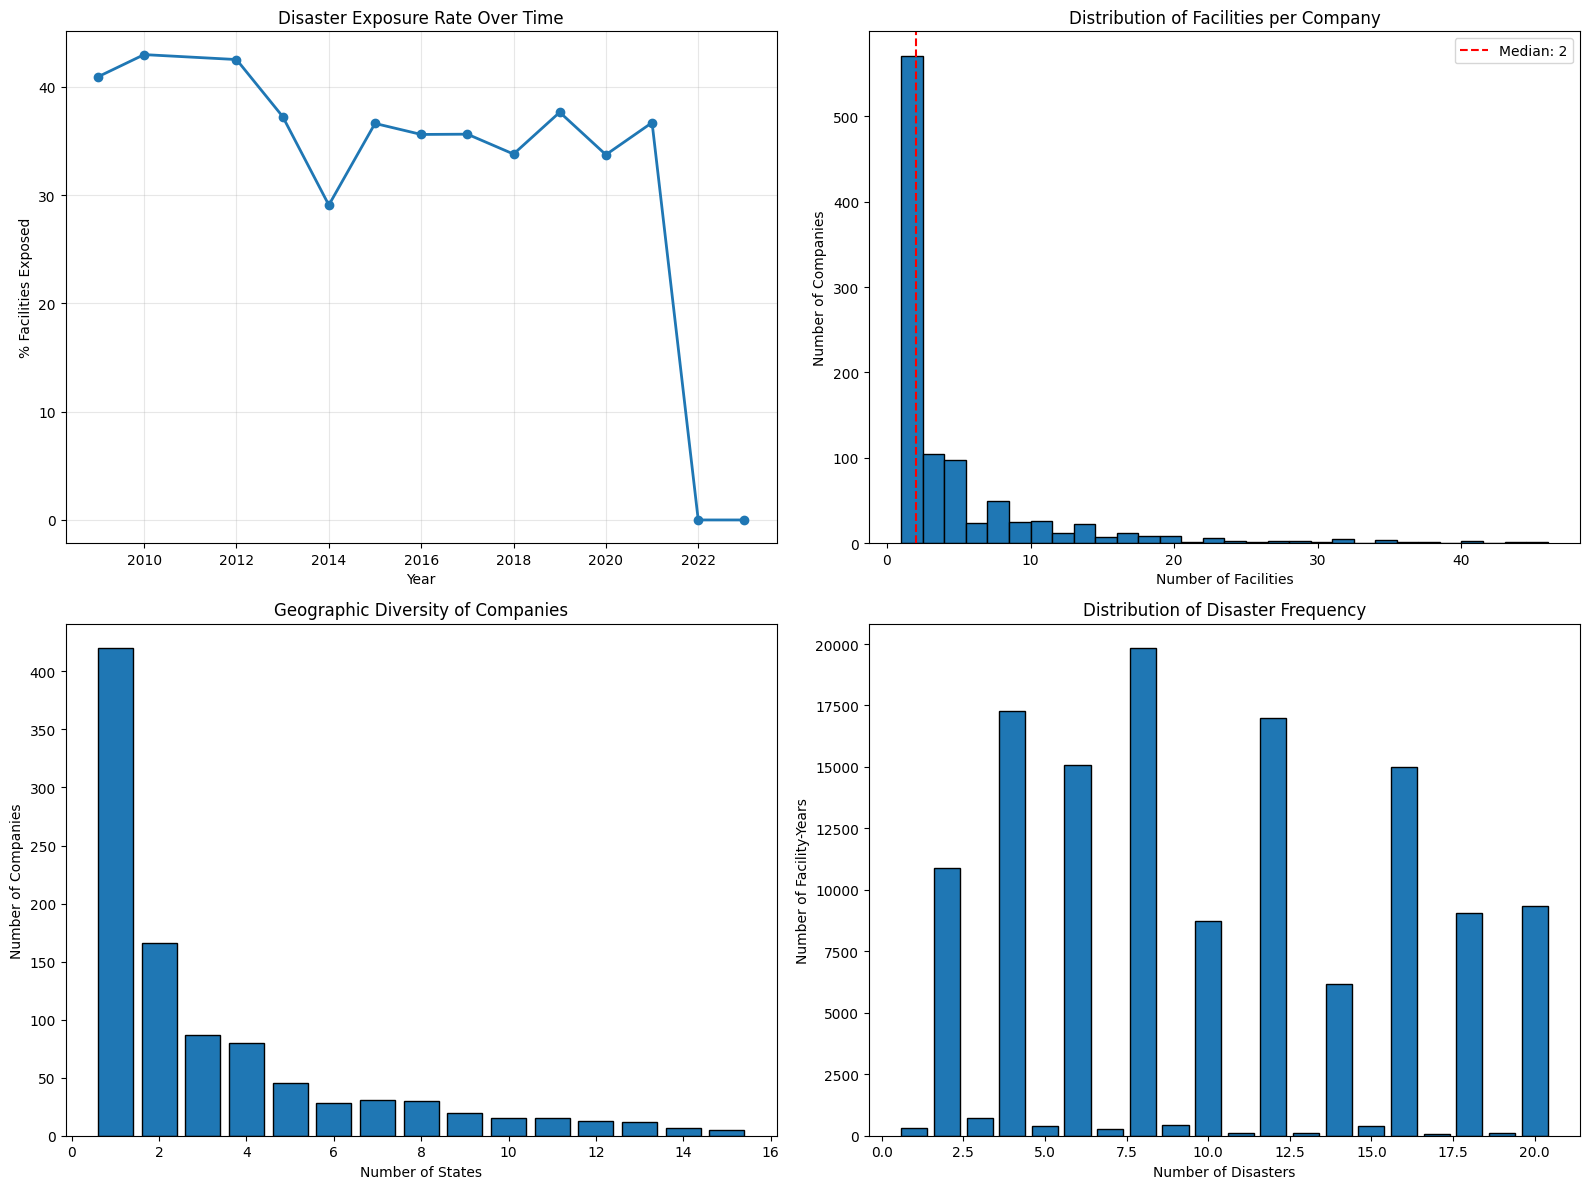


✓ Visualizations saved



In [ ]:
print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Disaster exposure over time
ax1 = axes[0, 0]
yearly_exposure = tri_matched.groupby('DATA_YEAR')['disaster_exposed'].mean() * 100
ax1.plot(yearly_exposure.index, yearly_exposure.values, marker='o', linewidth=2)
ax1.set_xlabel('Year')
ax1.set_ylabel('% Facilities Exposed')
ax1.set_title('Disaster Exposure Rate Over Time')
ax1.grid(True, alpha=0.3)

# 2. Distribution of facilities per company
ax2 = axes[0, 1]
facilities_dist = resilience_metrics['total_facilities']
ax2.hist(facilities_dist[facilities_dist <= 50], bins=30, edgecolor='black')
ax2.set_xlabel('Number of Facilities')
ax2.set_ylabel('Number of Companies')
ax2.set_title('Distribution of Facilities per Company')
ax2.axvline(facilities_dist.median(), color='red', linestyle='--', label=f'Median: {facilities_dist.median():.0f}')
ax2.legend()

# 3. Geographic concentration
ax3 = axes[1, 0]
states_dist = resilience_metrics['states_operating'].value_counts().sort_index()
ax3.bar(states_dist.index[:15], states_dist.values[:15], edgecolor='black')
ax3.set_xlabel('Number of States')
ax3.set_ylabel('Number of Companies')
ax3.set_title('Geographic Diversity of Companies')

# 4. Disaster frequency distribution
ax4 = axes[1, 1]
disaster_dist = tri_matched[tri_matched['num_disasters'] > 0]['num_disasters'].value_counts().sort_index()
ax4.bar(disaster_dist.index[:20], disaster_dist.values[:20], edgecolor='black')
ax4.set_xlabel('Number of Disasters')
ax4.set_ylabel('Number of Facility-Years')
ax4.set_title('Distribution of Disaster Frequency')

plt.tight_layout()
plt.savefig(PROCESSED_PATH / 'research_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved")
print("\n" + "="*80)

## 11. Create Analysis Dataset for Modeling

In [ ]:
print("="*80)
print("CREATING FINAL ANALYSIS DATASET")
print("="*80)

# Merge all metrics for econometric analysis
analysis_dataset = tri_matched.copy()

# Add company-level resilience metrics
analysis_dataset = analysis_dataset.merge(
    resilience_metrics,
    left_on='PERMNO',
    right_index=True,
    how='left',
    suffixes=('', '_company')
)

# Create additional variables
analysis_dataset['post_disaster'] = (analysis_dataset['disaster_exposed'] == 1).astype(int)
analysis_dataset['multi_state_firm'] = (analysis_dataset['states_operating'] > 1).astype(int)
analysis_dataset['large_firm'] = (analysis_dataset['total_facilities'] > analysis_dataset['total_facilities'].median()).astype(int)

# Summary
print(f"\nFinal dataset:")
print(f"  Observations: {len(analysis_dataset):,}")
print(f"  Variables: {len(analysis_dataset.columns)}")
print(f"  Memory usage: {analysis_dataset.memory_usage(deep=True).sum() / 1e6:.1f} MB")

print(f"\nKey variables included:")
print(f"  - Disaster exposure indicators")
print(f"  - Geographic diversity metrics")
print(f"  - Operational continuity measures")
print(f"  - Facility characteristics")
print(f"  - Company identifiers (PERMNO, TICKER, CUSIP)")

# Save
output_file = PROCESSED_PATH / 'analysis_dataset_complete.parquet'
analysis_dataset.to_parquet(output_file, index=False)
print(f"\n✓ Saved: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1e6:.1f} MB")

# Also save CSV for easier inspection
csv_file = PROCESSED_PATH / 'analysis_dataset_complete.csv'
analysis_dataset.to_csv(csv_file, index=False)
print(f"✓ Saved CSV: {csv_file}")

print("\n" + "="*80)

CREATING FINAL ANALYSIS DATASET

Final dataset:
  Observations: 1,148,673
  Variables: 43
  Memory usage: 1594.1 MB

Key variables included:
  - Disaster exposure indicators
  - Geographic diversity metrics
  - Operational continuity measures
  - Facility characteristics
  - Company identifiers (PERMNO, TICKER, CUSIP)

✓ Saved: /content/drive/MyDrive/Paper1_Dataset/processed/analysis_dataset_complete.parquet
  File size: 42.8 MB
✓ Saved CSV: /content/drive/MyDrive/Paper1_Dataset/processed/analysis_dataset_complete.csv



## 12. Research Framework Summary

In [ ]:
print("="*80)
print("RESEARCH ANALYSIS FRAMEWORK SUMMARY")
print("="*80)

print("\n📊 DATA PREPARATION: COMPLETE")
print("-" * 80)
print("✓ TRI-CRSP matching done")
print("✓ Disaster exposure linked")
print("✓ Resilience metrics calculated")
print("✓ Analysis dataset created")

print("\n📈 SUGGESTED ECONOMETRIC ANALYSES:")
print("-" * 80)
print("\n1. DIFFERENCE-IN-DIFFERENCES")
print("   Research question: Do disasters affect facility operations?")
print("   Model: Yit = α + β(Disaster_it) + γXit + δi + θt + εit")
print("   Where:")
print("     - Yit = Operational outcome (emissions, reporting)")
print("     - Disaster_it = Disaster exposure indicator")
print("     - Xit = Control variables")
print("     - δi = Facility fixed effects")
print("     - θt = Year fixed effects")

print("\n2. EVENT STUDY")
print("   Research question: What is the timeline of disaster impact?")
print("   Model: Yit = α + Σ βk·D(t=k) + γXit + δi + θt + εit")
print("   Where k ∈ {-2, -1, 0, +1, +2} around disaster year")

print("\n3. RESILIENCE DETERMINANTS")
print("   Research question: What factors predict resilience?")
print("   Model: Recovery_i = α + β1·Size_i + β2·Diversity_i + β3·Financial_i + εi")
print("   Where:")
print("     - Recovery_i = Speed of operational recovery")
print("     - Size_i = Firm size (facilities, assets)")
print("     - Diversity_i = Geographic diversification")
print("     - Financial_i = Financial strength ratios")

print("\n4. STOCK MARKET REACTION")
print("   Research question: How do investors value disaster exposure?")
print("   Model: Returns_it = α + β·Disaster_it + γ·Resilience_i + controls + εit")
print("   Requires: CRSP daily/monthly returns data")

print("\n📁 NEXT DATA REQUIREMENTS:")
print("-" * 80)
print("1. SEC EDGAR financial statements")
print("   → Calculate ROA, ROE, leverage, liquidity ratios")
print("2. CRSP stock returns")
print("   → Event study analysis")
print("   → Market-based performance metrics")
print("3. TRI detailed emissions data")
print("   → Operational intensity measures")
print("   → Production proxy variables")

print("\n✅ FILES CREATED:")
print("-" * 80)
print("1. analysis_dataset_complete.parquet - Main analysis file")
print("2. company_disaster_summary.csv - Company-year disaster exposure")
print("3. company_resilience_metrics.csv - Resilience indicators")
print("4. disaster_event_study_panel.parquet - Event study data")
print("5. research_visualizations.png - Descriptive charts")

print("\n" + "="*80)
print("🎯 READY FOR ECONOMETRIC ANALYSIS!")
print("="*80)

RESEARCH ANALYSIS FRAMEWORK SUMMARY

📊 DATA PREPARATION: COMPLETE
--------------------------------------------------------------------------------
✓ TRI-CRSP matching done
✓ Disaster exposure linked
✓ Resilience metrics calculated
✓ Analysis dataset created

📈 SUGGESTED ECONOMETRIC ANALYSES:
--------------------------------------------------------------------------------

1. DIFFERENCE-IN-DIFFERENCES
   Research question: Do disasters affect facility operations?
   Model: Yit = α + β(Disaster_it) + γXit + δi + θt + εit
   Where:
     - Yit = Operational outcome (emissions, reporting)
     - Disaster_it = Disaster exposure indicator
     - Xit = Control variables
     - δi = Facility fixed effects
     - θt = Year fixed effects

2. EVENT STUDY
   Research question: What is the timeline of disaster impact?
   Model: Yit = α + Σ βk·D(t=k) + γXit + δi + θt + εit
   Where k ∈ {-2, -1, 0, +1, +2} around disaster year

3. RESILIENCE DETERMINANTS
   Research question: What factors predict resi

In [ ]:
print("="*80)
print("DIAGNOSTIC: TRACING DISASTER DATA LOSS")
print("="*80)

# 1. Check facility-level disaster data
print("\n1. FACILITY-LEVEL DATA (analysis_dataset_complete.parquet):")
facility_data = pd.read_parquet(PROCESSED_PATH / 'analysis_dataset_complete.parquet')

print(f"   Total facility-years: {len(facility_data):,}")
print(f"   With disasters (num_disasters > 0): {(facility_data['num_disasters'] > 0).sum():,}")
print(f"   Disaster rate: {(facility_data['num_disasters'] > 0).sum()/len(facility_data)*100:.1f}%")

# Check matched facilities only
matched = facility_data[facility_data['PERMNO'].notna()]
print(f"\n   Matched facilities (with PERMNO): {len(matched):,}")
print(f"   With disasters: {(matched['num_disasters'] > 0).sum():,}")
print(f"   Disaster rate: {(matched['num_disasters'] > 0).sum()/len(matched)*100:.1f}%")

# 2. Check company-year panel
print("\n2. COMPANY-YEAR PANEL (company_year_panel_with_affected_ratio.parquet):")
company_data = pd.read_parquet(PROCESSED_PATH / 'company_year_panel_with_affected_ratio.parquet')

print(f"   Company-years: {len(company_data):,}")
print(f"   Year range: {company_data['YEAR'].min()}-{company_data['YEAR'].max()}")
print(f"   With DISASTER=1: {(company_data['DISASTER'] == 1).sum():,}")
print(f"   With num_disasters > 0: {(company_data['num_disasters'] > 0).sum():,}")
print(f"   AFFECTED_RATIO > 0: {(company_data['AFFECTED_RATIO'] > 0).sum():,}")

# 3. Show sample
print("\n3. SAMPLE OF COMPANY DATA:")
print(company_data[['PERMNO', 'YEAR', 'total_facilities', 'exposed_facilities', 'num_disasters', 'AFFECTED_RATIO', 'DISASTER']].head(20).to_string(index=False))

# 4. Statistics
print("\n4. AFFECTED_RATIO STATISTICS:")
print(f"   Mean: {company_data['AFFECTED_RATIO'].mean():.6f}")
print(f"   Median: {company_data['AFFECTED_RATIO'].median():.6f}")
print(f"   Max: {company_data['AFFECTED_RATIO'].max():.6f}")
print(f"   Min: {company_data['AFFECTED_RATIO'].min():.6f}")

print("\n5. CHECKING FOR YEAR MISMATCH:")
print(f"   Facility data years: {sorted(facility_data['DATA_YEAR'].unique())}")
print(f"   Company panel years: {sorted(company_data['YEAR'].unique())}")

print("="*80)

DIAGNOSTIC: TRACING DISASTER DATA LOSS

1. FACILITY-LEVEL DATA (analysis_dataset_complete.parquet):
   Total facility-years: 1,148,673
   With disasters (num_disasters > 0): 364,620
   Disaster rate: 31.7%

   Matched facilities (with PERMNO): 245,826
   With disasters: 76,911
   Disaster rate: 31.3%

2. COMPANY-YEAR PANEL (company_year_panel_with_affected_ratio.parquet):
   Company-years: 2,341
   Year range: 2016-2023
   With DISASTER=1: 0
   With num_disasters > 0: 0
   AFFECTED_RATIO > 0: 0

3. SAMPLE OF COMPANY DATA:
 PERMNO  YEAR  total_facilities  exposed_facilities  num_disasters  AFFECTED_RATIO  DISASTER
10032.0  2016                 3                   0            0.0             0.0         0
10032.0  2017                 3                   0            0.0             0.0         0
10032.0  2018                 3                   0            0.0             0.0         0
10032.0  2019                 3                   0            0.0             0.0         0
10032.0